In [1]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from torchsummary import summary

import rasterio as rio
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from milesial_unet.unet_model import UNet

In [1]:
import os

In [4]:
path = 'path/to/your/data'
os.path.split(path)

('path/to/your', 'data')

In [18]:
import csv
path = r'C:\Users\User\OneDrive - Université Bretagne Sud\01_Masters_Thesis\Project\legends\lgd_siam_96.csv'
# Open the CSV file
with open(path, mode='r') as file:
    reader = csv.DictReader(file, delimiter=',')  
    rgb_dict = {}
    for row in reader:
        #print(row)
        value = int(row['value'])
        rgb = tuple(map(int, row['rgb'][1:-1].split(',')))  # Convert "(r, g, b)" string to tuple
        rgb_dict[value] = rgb

# Print the dictionary
print(rgb_dict)
for value, rgb in rgb_dict.items():
    print(rgb[2])
    break


{1: (30, 250, 30), 2: (30, 235, 30), 3: (30, 215, 30), 4: (30, 200, 30), 5: (20, 190, 20), 6: (20, 175, 20), 7: (20, 160, 20), 8: (0, 240, 90), 9: (0, 220, 90), 10: (0, 205, 90), 11: (0, 190, 110), 12: (0, 170, 110), 13: (0, 120, 110), 14: (175, 250, 140), 15: (100, 150, 70), 16: (120, 65, 85), 17: (100, 120, 80), 18: (180, 255, 50), 19: (190, 250, 160), 20: (180, 230, 140), 21: (160, 220, 140), 22: (150, 200, 130), 23: (140, 170, 110), 24: (130, 150, 90), 25: (225, 250, 50), 26: (200, 160, 50), 27: (200, 200, 100), 28: (100, 100, 50), 29: (20, 75, 70), 30: (100, 130, 120), 31: (175, 255, 255), 32: (30, 70, 30), 33: (230, 210, 210), 34: (255, 170, 110), 35: (210, 200, 200), 36: (240, 150, 100), 37: (210, 210, 210), 38: (230, 155, 95), 39: (190, 180, 180), 40: (200, 125, 75), 41: (195, 195, 195), 42: (185, 185, 185), 43: (210, 140, 100), 44: (160, 120, 90), 45: (160, 100, 70), 46: (160, 80, 50), 47: (170, 170, 170), 48: (155, 155, 155), 49: (180, 100, 70), 50: (130, 90, 80), 51: (130, 7

In [3]:
# modifying class to have only one band in label
class SiamDW_DataClass(Dataset):
    def __init__(self, data_path, metadata, set, learn_type, process_level, transform=None):
    # in metadata dataframe, select patches with set as train 
        self.data_path = data_path
        self.metadata = metadata
        self.set = set
        self.transform = transform
        self.process_level = process_level
        self.learn_type = learn_type

    def __len__(self):
        return len(self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)])

    def __getitem__(self, idx):
        # return tensor pair feature,label
        # read image
        metadata_set = self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)]
        feat_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"feats.tif")
        label_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"label.tif")

        feat_p = os.path.join(self.data_path, feat_fname)
        label_p = os.path.join(self.data_path, label_fname)
        
        with rio.open(feat_p) as src:
            feat = src.read().astype(np.int16)
        with rio.open(label_p) as src:
            label = src.read().astype(np.int16)

        # handle dtypes for tensor
        feat = torch.from_numpy(feat).to(torch.float32)
        label = torch.from_numpy(label).to(torch.float32)
        # if self.transform:
        #     feat = self.transform(feat)
            # label = self.transform(label)
        return feat, label[5,:,:].long()

In [ ]:
# data_path = r"C:\Users\User\OneDrive - Université Bretagne Sud\01_Masters_Thesis\Project\data\toy\l1c\train"
# data_path = data_path.replace("\\", "/")
train_data_path = r"E:\Thesis\toy\l1c\train"
test_data_path = r"E:\Thesis\toy\l1c\test"
meta_path =  r"E:\Thesis\toy\meta_patches.csv"
metadata = pd.read_csv(meta_path)

In [4]:
batch_size = 4
train_dataset = SiamDW_DataClass(train_data_path, metadata, 'train', 'csl','l1c')
test_dataset = SiamDW_DataClass(test_data_path, metadata, 'test', 'csl','l1c')

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
def train_epoch(model, data, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    for _,batch in enumerate(tqdm(data, desc='Training', leave=False)): # for each batch
        #print(f"Batch {i}")
        features, labels = batch
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        outputs = outputs.view(4,10,-1)
        labels = labels.view(4,-1).long()
    
        loss = criterion(outputs, labels) # loss
        loss.backward()
        optimizer.step()

        # loss and number of correct predictions of the batch
        running_loss += loss.item() # loss per batch
        preds= torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
    
    avg_loss = running_loss / len(data)
    overall_accuracy = correct_preds / (len(data) * batch_size * 510 * 510)
    return avg_loss, overall_accuracy 

def validate_epoch(model, data, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    with torch.no_grad():
        #data_with_progress = tqdm(data, desc='Validation', leave=False)

        for _,batch in enumerate(tqdm(data, desc='Validation', leave=False)):
            features, labels = batch
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            labels, outputs = labels.view(4,-1).long(), outputs.view(4,10,-1)
            loss = criterion(outputs, labels)
            
            # loss and number of correct predictions of the batch
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()

    avg_loss = running_loss / len(data)
    overall_accuracy = correct_preds / (len(data) * batch_size * 510 * 510)
    return avg_loss, overall_accuracy

In [9]:
# early stopping, checkpoint
def train_model(model, train_data, val_data, optimizer, scheduler, criterion, device, patience,out_model_path, epochs=10):
    start = time.time()
    model = model.to(device)

    min_val_loss = np.inf
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs} started")
        train_epoch_loss, train_epoch_accuracy = train_epoch(model, train_data, optimizer, criterion, device)
        val_epoch_loss, val_epoch_accuracy = validate_epoch(model, val_data, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f} , 
              Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")
        
        train_loss_history.append(train_epoch_loss)
        val_loss_history.append(val_epoch_loss)
        train_accuracy_history.append(train_epoch_accuracy)
        val_accuracy_history.append(val_epoch_accuracy)

        patience_counter = 0
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            
            ckpt = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                    'train_loss_history': train_loss_history,
                    'train_accuracy_history': train_accuracy_history,
                    'val_loss_history': val_loss_history,
                    'val_accuracy_history': val_accuracy_history,
                    'loss': min_val_loss
                }
            torch.save(ckpt, out_model_path)
            print("Model saved") # saves the last best model, overwrites the previous best one
        else:
            patience_counter += 1
            if patience_counter == patience:
                print(f"Early stopping at epoch {epoch}")
                break
        if scheduler is not None:
            scheduler.step(val_epoch_loss)

    train_duration = time.time() - start
    print(f"Training completed in {train_duration//60:.0f}m {train_duration % 60:.0f}s")

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(10, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = torch.nn.CrossEntropyLoss()
patience = 5
out_model_path = 'model.pth'
epochs = 10

In [2]:
model = UNet(10, 10)
summary(model, (10, 510, 510))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           5,760
       BatchNorm2d-2         [-1, 64, 510, 510]             128
              ReLU-3         [-1, 64, 510, 510]               0
            Conv2d-4         [-1, 64, 510, 510]          36,864
       BatchNorm2d-5         [-1, 64, 510, 510]             128
              ReLU-6         [-1, 64, 510, 510]               0
        DoubleConv-7         [-1, 64, 510, 510]               0
         MaxPool2d-8         [-1, 64, 255, 255]               0
            Conv2d-9        [-1, 128, 255, 255]          73,728
      BatchNorm2d-10        [-1, 128, 255, 255]             256
             ReLU-11        [-1, 128, 255, 255]               0
           Conv2d-12        [-1, 128, 255, 255]         147,456
      BatchNorm2d-13        [-1, 128, 255, 255]             256
             ReLU-14        [-1, 128, 2

In [ ]:
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_data, test_data, optimizer, scheduler, 
                                                   criterion, device, patience, out_model_path, epochs)

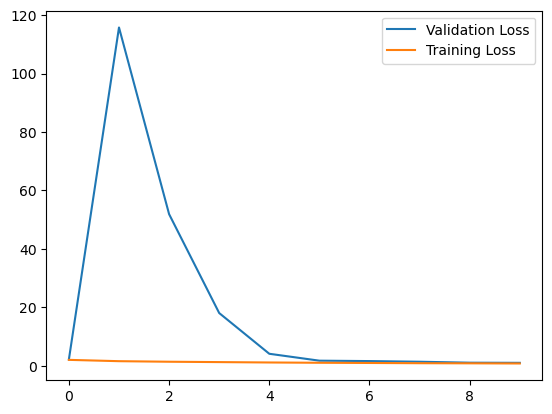

In [12]:
#load model
ckpt = torch.load(out_model_path)
val = ckpt['val_loss_history']
train = ckpt['train_loss_history']

plt.plot(val, label='Validation Loss')
plt.plot(train, label='Training Loss')
plt.legend()
plt.show()

In [ ]:
# horizontal subplots of the accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(val_accuracy_history, label='Validation Accuracy')
axs[0].plot(train_accuracy_history, label='Training Accuracy')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(val_loss_history, label='Validation Loss')
axs[1].plot(train_loss_history, label='Training Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.show()

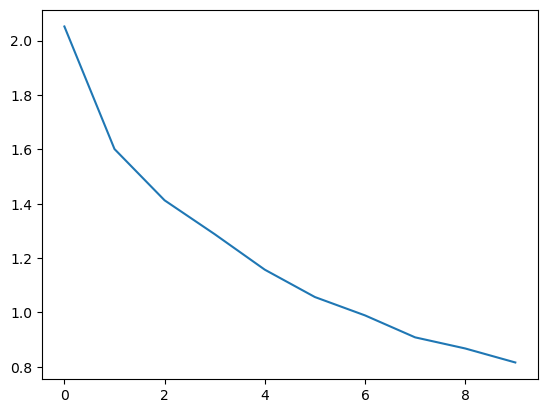

In [13]:
plt.plot(train)